# Importer les librairies

In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob

from tqdm import tqdm_notebook
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import load_model, Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

%matplotlib inline
tf.__version__


'2.12.0'

In [2]:


import seaborn as sns
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image

tf.random.set_seed(3)
from tensorflow import keras
from tensorflow.math import confusion_matrix


# 1.Importer les donnees

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
image_size = (256, 256)
batch_size = 16

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/dog',
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 401 files belonging to 2 classes.
Using 321 files for training.
Using 80 files for validation.


In [5]:
data_iterator = train_ds.as_numpy_iterator()

In [6]:
batch = data_iterator.next()

In [7]:
batch[0].shape

(16, 256, 256, 3)

In [8]:
batch[0]

array([[[[ 95.37152  ,  86.37152  ,  57.37152  ],
         [100.84927  ,  91.84927  ,  62.849274 ],
         [ 97.30757  ,  88.30757  ,  59.30757  ],
         ...,
         [ 78.97359  ,  74.62407  ,  43.533203 ],
         [ 77.31021  ,  63.599274 ,  39.31021  ],
         [ 70.56174  ,  55.561737 ,  32.561737 ]],

        [[ 97.80614  ,  88.354965 ,  60.25731  ],
         [ 95.57176  ,  85.21825  ,  57.571762 ],
         [ 92.775116 ,  82.87277  ,  54.323944 ],
         ...,
         [ 81.156525 ,  75.59961  ,  45.112442 ],
         [ 78.201614 ,  64.49068  ,  40.201614 ],
         [ 76.94319  ,  61.94319  ,  38.94319  ]],

        [[ 89.29883  ,  77.79492  ,  51.546875 ],
         [ 83.68834  ,  71.68834  ,  45.68834  ],
         [ 82.728516 ,  71.728516 ,  43.728516 ],
         ...,
         [ 80.87891  ,  74.64453  ,  44.496094 ],
         [ 81.07338  ,  67.36244  ,  43.07338  ],
         [ 85.82236  ,  70.82236  ,  47.822357 ]],

        ...,

        [[183.12984  , 151.12984  , 11

# 2. Preprocess Data

**data augmentation**

In [9]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

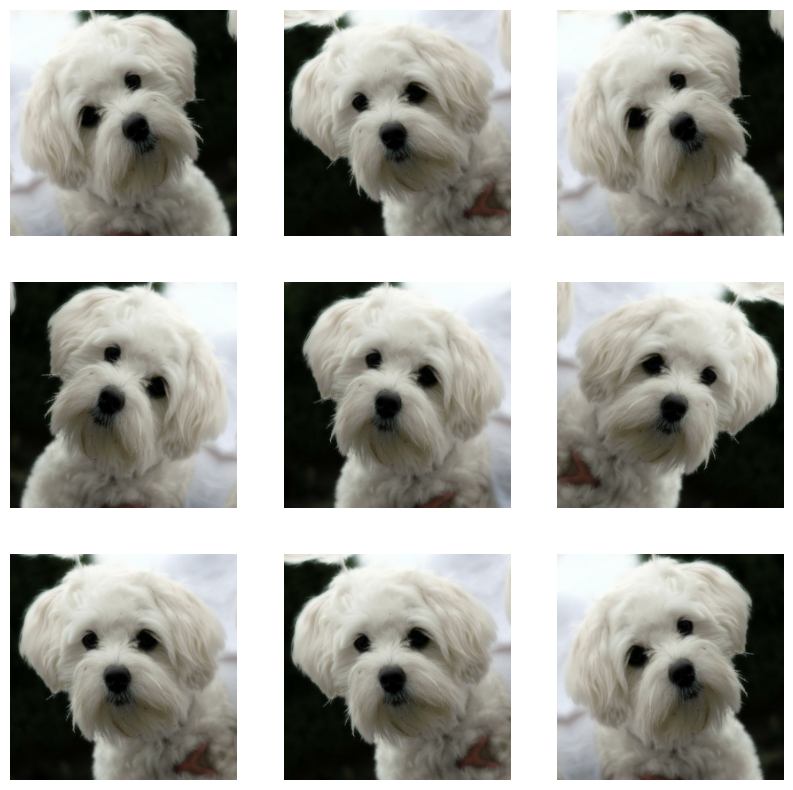

In [10]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [11]:
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

In [12]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

# VGG16

In [13]:
from keras.applications.vgg16 import VGG16

In [14]:
img_shape = (256,256,3)
base_model = VGG16(input_shape=img_shape, include_top=False, weights='imagenet')

58889256/58889256 [==============================] - 4s 0us/step


In [15]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [16]:
base_model.trainable = False

In [17]:
base_model.output

<KerasTensor: shape=(None, 8, 8, 512) dtype=float32 (created by layer 'block5_pool')>

In [18]:
# our layers - you can add more if you want
x = Flatten()(base_model.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(1, activation="sigmoid")(x)  # classification binary

In [19]:
model = Model(inputs=base_model.input, outputs=prediction)

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [21]:
 model.compile(  loss='binary_crossentropy', # classification binary, sinon "categorical_crossentropy"
  optimizer='adam', 
  metrics=['accuracy'])

In [22]:
history = model.fit_generator(train_ds, epochs=5, validation_data=val_ds)

Epoch 1/5


<ipython-input-22-74bbd506e9a4>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_ds, epochs=5, validation_data=val_ds)


21/21 [==============================] - 69s 3s/step - loss: 4.7025 - accuracy: 0.7539 - val_loss: 1.4245 - val_accuracy: 0.9250
Epoch 2/5
21/21 [==============================] - 3s 137ms/step - loss: 1.3417 - accuracy: 0.9190 - val_loss: 2.4030 - val_accuracy: 0.9250
Epoch 3/5
21/21 [==============================] - 3s 137ms/step - loss: 0.8834 - accuracy: 0.9595 - val_loss: 1.7771 - val_accuracy: 0.8750
Epoch 4/5
21/21 [==============================] - 4s 194ms/step - loss: 0.5880 - accuracy: 0.9470 - val_loss: 2.9167 - val_accuracy: 0.8750
Epoch 5/5
21/21 [==============================] - 3s 141ms/step - loss: 0.4127 - accuracy: 0.9657 - val_loss: 1.9777 - val_accuracy: 0.9000


In [23]:
valid_loss, valid_accuracy = model.evaluate_generator(val_ds)

<ipython-input-23-9aac268120ef>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  valid_loss, valid_accuracy = model.evaluate_generator(val_ds)


In [24]:
print("Accuracy after transfer learning: {}".format(valid_accuracy))

Accuracy after transfer learning: 0.8999999761581421


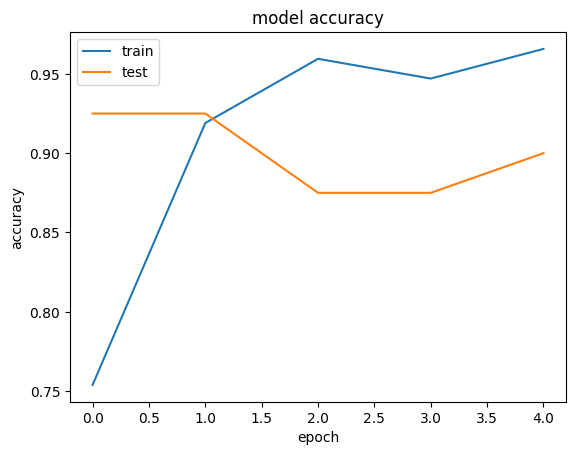

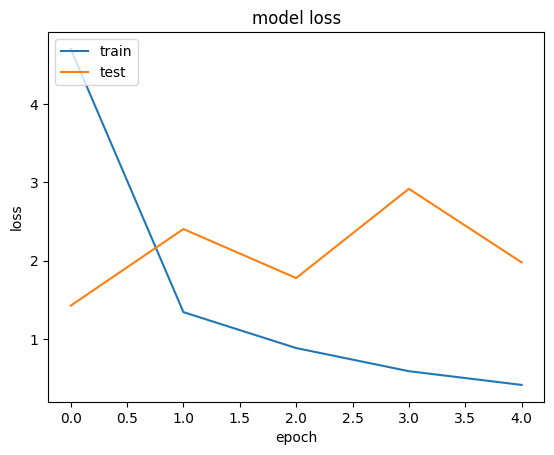

In [25]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# CNN

Convolutional Neural Network
- Detercter les caracteristique d'une photo
- 

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [27]:
model = Sequential()

In [28]:
model.add(Conv2D(16, (3,3),1, activation='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3),1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3),1, activation='relu'))
model.add(MaxPooling2D())


model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [29]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(),metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)      

In [31]:
hist = model.fit(train_ds, epochs=5, validation_data = val_ds )

Epoch 1/5
21/21 [==============================] - 8s 182ms/step - loss: 41.2147 - accuracy: 0.5389 - val_loss: 1.3668 - val_accuracy: 0.5500
Epoch 2/5
21/21 [==============================] - 3s 109ms/step - loss: 0.6965 - accuracy: 0.5826 - val_loss: 0.7759 - val_accuracy: 0.5625
Epoch 3/5
21/21 [==============================] - 3s 108ms/step - loss: 0.6343 - accuracy: 0.6324 - val_loss: 0.7939 - val_accuracy: 0.5500
Epoch 4/5
21/21 [==============================] - 3s 114ms/step - loss: 0.6137 - accuracy: 0.6791 - val_loss: 1.0732 - val_accuracy: 0.6125
Epoch 5/5
21/21 [==============================] - 3s 141ms/step - loss: 0.6253 - accuracy: 0.6636 - val_loss: 0.8397 - val_accuracy: 0.5500


# Model 

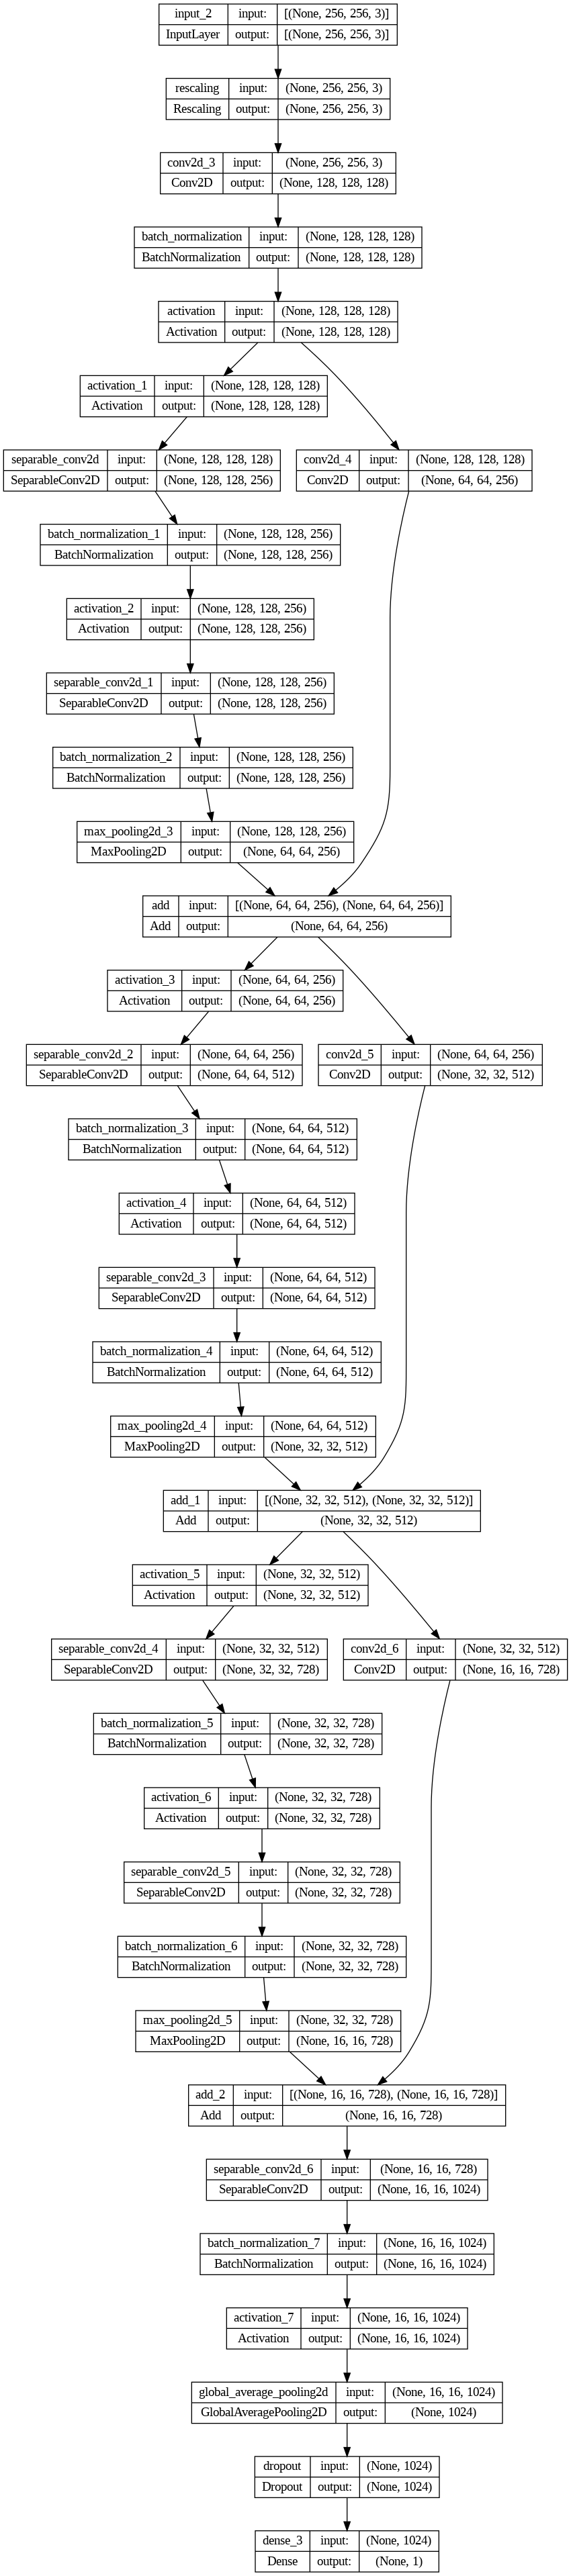

In [32]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

**Train the model**

In [33]:
epochs = 4

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history=model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/4
21/21 [==============================] - 21s 330ms/step - loss: 0.6815 - accuracy: 0.6573 - val_loss: 0.6916 - val_accuracy: 0.5250
Epoch 2/4
21/21 [==============================] - 7s 299ms/step - loss: 0.6472 - accuracy: 0.6854 - val_loss: 0.6913 - val_accuracy: 0.5250
Epoch 3/4
21/21 [==============================] - 6s 287ms/step - loss: 0.6092 - accuracy: 0.6916 - val_loss: 0.6906 - val_accuracy: 0.5250
Epoch 4/4
21/21 [==============================] - 7s 293ms/step - loss: 0.5868 - accuracy: 0.6947 - val_loss: 0.6914 - val_accuracy: 0.5250
